Task 2 – Evaluate the sentiment‑analysis results produced in Task 1.
-------------------------------------------------------------------
•  Reads the parallel‑output directory  sentiment_output/  created by task1.py
•  Converts star_rating to ground‑truth labels  (POSITIVE / NEGATIVE)
•  Ignores 3‑star reviews to keep the task strictly binary
•  Computes TP, FP, TN, FN in Spark
•  Prints Precision, Recall and the confusion matrix

In [1]:
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when


## 1. Spark session (quiet logging)  

In [2]:
spark = (
    SparkSession.builder.appName("GourmetSentiment‑Eval")
    .config("spark.sql.shuffle.partitions", "4")   # keep memory use low
    .config("spark.default.parallelism", "4")
    .getOrCreate()
)
spark.sparkContext.setLogLevel("ERROR")


25/04/23 05:34:58 WARN Utils: Your hostname, amar-Swift-SFG14-71 resolves to a loopback address: 127.0.1.1; using 192.168.0.111 instead (on interface wlp0s20f3)
25/04/23 05:34:58 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/23 05:34:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## 2. Loading the predictions written in Task 1  

In [3]:
PRED_DIR = "sentiment_output"          
df = spark.read.csv(PRED_DIR, header=True)

# Ensuring correct dtypes
df = df.withColumn("star_rating", col("star_rating").cast("float"))


## 3. Ground‑truth label: 
Positive(rating >= 3), Negative(rating <= 2)  

In [4]:
df = df.withColumn(
    "true_sentiment",
    when(col("star_rating") >= 3.0, "POSITIVE").otherwise("NEGATIVE")
)



## 4. Confusion‑matrix counts (map‑reduce style)   

In [5]:
df_cm = (
    df.select(
        when(
            (col("true_sentiment") == "POSITIVE")
            & (col("predicted_sentiment") == "POSITIVE"),
            1,
        ).alias("TP"),
        when(
            (col("true_sentiment") == "POSITIVE")
            & (col("predicted_sentiment") == "NEGATIVE"),
            1,
        ).alias("FN"),
        when(
            (col("true_sentiment") == "NEGATIVE")
            & (col("predicted_sentiment") == "NEGATIVE"),
            1,
        ).alias("TN"),
        when(
            (col("true_sentiment") == "NEGATIVE")
            & (col("predicted_sentiment") == "POSITIVE"),
            1,
        ).alias("FP"),
    )
)

agg = df_cm.groupBy().sum("TP", "FP", "TN", "FN").collect()[0]
TP, FP, TN, FN = (int(agg["sum(TP)"] or 0),
                  int(agg["sum(FP)"] or 0),
                  int(agg["sum(TN)"] or 0),
                  int(agg["sum(FN)"] or 0))


## 5. Metrics  

In [6]:
precision = TP / (TP + FP) if (TP + FP) else 0.0
recall    = TP / (TP + FN) if (TP + FN) else 0.0

## 6. Display

In [7]:
print("\n=== Confusion Matrix ===")
print(f"TP: {TP:6d}   FP: {FP:6d}")
print(f"FN: {FN:6d}   TN: {TN:6d}")

print("\n=== Metrics ===")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}\n")

spark.stop()


=== Confusion Matrix ===
TP: 106901   FP:   2389
FN:  26832   TN:  18513

=== Metrics ===
Precision: 0.9781
Recall   : 0.7994



## 7. Heat‑map of the confusion matrixa and Bar chart for Precision & Recall                                

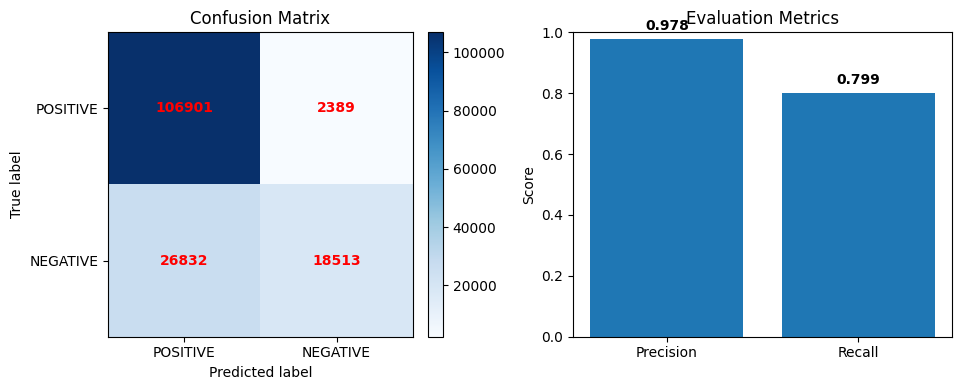

In [8]:
import matplotlib.pyplot as plt
import numpy as np


cm = np.array([[TP, FP],
               [FN, TN]])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))      # 1 row, 2 columns

# ── Confusion‑matrix heat‑map ────────────────────────────
im = ax1.imshow(cm, cmap="Blues")

ax1.set_xticks([0, 1])
ax1.set_yticks([0, 1])
ax1.set_xticklabels(["POSITIVE", "NEGATIVE"])
ax1.set_yticklabels(["POSITIVE", "NEGATIVE"])
ax1.set_xlabel("Predicted label")
ax1.set_ylabel("True label")
ax1.set_title("Confusion Matrix")

# Annotate each cell
for i in range(2):
    for j in range(2):
        ax1.text(j, i, cm[i, j],
                 ha="center", va="center",
                 color="red", weight="bold")

# Optional color‑bar for the heat‑map
fig.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)

# ── Precision / Recall bar‑chart ─────────────────────────
metrics = ["Precision", "Recall"]
values  = [precision,  recall]

ax2.bar(metrics, values)
ax2.set_ylim(0, 1)
ax2.set_ylabel("Score")
ax2.set_title("Evaluation Metrics")

for idx, val in enumerate(values):
    ax2.text(idx, val + 0.02,
             f"{val:.3f}",
             ha="center", va="bottom",
             weight="bold")

plt.tight_layout()
plt.show()
